In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import seaborn as sns

from src.data import PrepareData
from src.data import plot_catchments, read_data_from_file
from src.window import MultiNumpyWindow, MultiWindow, WindowGenerator
from src.model import Switch_Model, QuantileEnsemble

2025-01-27 10:08:06.010713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737932886.275341 1239534 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737932886.360908 1239534 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 10:08:06.899164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Argument Parser
parser = argparse.ArgumentParser(description='Train Stage 3')
parser.add_argument('--data-dir', type=str, default='/srv/scratch/z5370003/data/camels-dropbox/', help='Path to the data directory')
parser.add_argument('--num-runs', type=int, default=1, help='Number of runs')
parser.add_argument('--state', type=str, default='SA', help='State to train the model on')
parser.add_argument('--input-width', type=int, default=5, help='Input width for the window')
parser.add_argument('--output-width', type=int, default=5, help='Output width for the window')
parser.add_argument('--shift', type=int, default=5, help='Shift for the window')

_StoreAction(option_strings=['--shift'], dest='shift', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Shift for the window', metavar=None)

/srv/scratch/z5370003/projects/streamflow-floods-fork/src/data.py:158: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.flood_indicator = self.flood_probabilities.applymap(lambda x: int(x <0.05) if pd.isnull(x) == False and isinstance(x, float) else x)


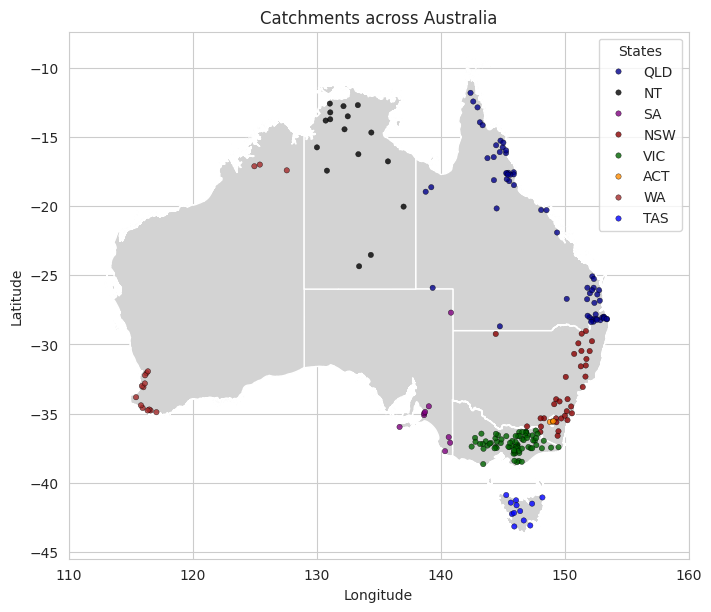

In [3]:
# Parse the arguments
args = parser.parse_args('')
data_dir = args.data_dir
num_runs = args.num_runs

# Read timeseries and summary data from data dir
timeseries_data, summary_data = read_data_from_file(data_dir)

# Create Dataset
camels_data = PrepareData(timeseries_data, summary_data)

# Plot catchments on map
plot_catchments(camels_data, data_dir)


camels_data.summary_data = camels_data.summary_data.T.drop_duplicates().T


In [4]:
char = camels_data.summary_data[['state_outlet', 'station_name', 'river_region', 'Q5', 'Q95', 'catchment_area', 'lat_outlet', 'long_outlet']]

# SA
args.state = 'SA'
# river_region = 'COOPER CREEK-BULLOO RIVER'

# # WA
# args.state = 'WA'
# river_region = 'SWAN COAST-AVON RIVER'

# # NSW
# args.state = 'NSW'
# river_region = 'HAWKESBURY RIVER'

# # QLD
# args.state = 'QLD'
# river_region = 'BURNETT RIVER'


char_selected = char[(char.state_outlet==args.state)] # & (char.river_region==river_region)]
selected_stations = char_selected.index.tolist()
selected_stations

['A0030501',
 'A5030502',
 'A5040517',
 'A5040523',
 'A5050517',
 'A5130501',
 'A2390519',
 'A2390523',
 'A2390531']

In [5]:
station_names = char_selected.station_name
char_selected.head(50)

,state_outlet,station_name,river_region,Q5,Q95,catchment_area,lat_outlet,long_outlet
station_id,,,,,,,,
A0030501,SA,Cooper Creek at Cullyamurra Water Hole (A0030501),COOPER CREEK-BULLOO RIVER,0.063072,0.0,233250.3,-27.7013,140.8433
A5030502,SA,Scott Creek at Scott Bottom (A5030502),ONKAPARINGA RIVER,1.435668,0.003209,26.8,-35.099167,138.673889
A5040517,SA,First Creek at Waterfall Gully (A5040517),TORRENS RIVER,2.158114,0.0425,5.1,-34.970278,138.681111
A5040523,SA,Sixth Creek at Castambul (A5040523),TORRENS RIVER,1.748248,0.017059,43.5,-34.873056,138.754444
A5050517,SA,North Para River at Penrice (A5050517),GAWLER RIVER,0.444348,0.0,116.3,-34.463333,139.058333
A5130501,SA,Rocky River upstream Gorge Falls (A5130501),KANGAROO ISLAND,0.866554,0.0,190.5,-35.955,136.697778
A2390519,SA,Mosquito Creek at Struan (A2390519),MILLICENT COAST,0.199066,0.0,1549.0,-37.0938,140.776
A2390523,SA,Stony Creek at Woakwine Range (A2390523),MILLICENT COAST,0.135544,0.0,485.4,-37.7034,140.3622
A2390531,SA,Morambro Creek at Bordertown-Naracoorte Road B...,MILLICENT COAST,0.075404,0.0,404.9,-36.689167,140.661111


In [6]:
variable_ts = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']

# variable_ts_switch = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
variable_static = ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']

train_df, test_df = camels_data.get_train_val_test(source=variable_ts, stations=selected_stations)

# multi_window = MultiWindow(input_width=args.input_width,
#                            label_width=args.output_width,
#                            shift=args.shift,
#                            train_df=train_df,
#                            test_df=test_df,
#                            stations=selected_stations,
#                            label_columns=['streamflow_MLd_inclInfilled'],
#                            batch_size=32)



np_window = MultiNumpyWindow(input_width=args.input_width, 
                             label_width=args.output_width,
                             shift=args.shift,
                             camels_data=camels_data,
                             timeseries_source=variable_ts,
                             summary_source=variable_static,
                             summary_data=camels_data.summary_data,
                             stations=selected_stations,
                             label_columns=['streamflow_MLd_inclInfilled'])

I0000 00:00:1737933017.665930 1239534 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0
2025-01-27 10:10:19.835104: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-27 10:10:20.252586: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-27 10:10:21.280419: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-27 10:10:23.339056: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-27 10:10:27.414863: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
quantile_ensemble = QuantileEnsemble(window=np_window, CONV_WIDTH=args.output_width)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ TIMESERIES_INPUT    │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_LAYER_1 (LSTM) │ (None, 5, 64)     │     18,176 │ TIMESERIES_INPUT… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_LAYER_2 (LSTM) │ (None, 5, 64)     │     33,024 │ LSTM_LAYER_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 2, 64)     │          0 │ LSTM_LAYER_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ STATIC_INPUT        │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLATTEN_LAYER       │ (None, 128)       │          0 │ get_item[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DENSE_LAYER_1       │ (None, 64)        │      1,088 │ STATIC_INPUT[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CONCATENATED_TIMES… │ (None, 192)       │          0 │ FLATTEN_LAYER[0]… │
│ (Concatenate)       │                   │            │ DENSE_LAYER_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DENSE_LAYER_2       │ (None, 32)        │      6,176 │ CONCATENATED_TIM… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OUTPUT_LAYER        │ (None, 5)         │        165 │ DENSE_LAYER_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,629 (229.02 KB)

 Trainable params: 58,629 (229.02 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1737933032.141084 1239751 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ TIMESERIES_INPUT    │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_LAYER_1 (LSTM) │ (None, 5, 64)     │     18,176 │ TIMESERIES_INPUT… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_LAYER_2 (LSTM) │ (None, 5, 64)     │     33,024 │ LSTM_LAYER_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 2, 64)     │          0 │ LSTM_LAYER_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ STATIC_INPUT        │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLATTEN_LAYER       │ (None, 128)       │          0 │ get_item_1[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DENSE_LAYER_1       │ (None, 64)        │      1,088 │ STATIC_INPUT[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CONCATENATED_TIMES… │ (None, 192)       │          0 │ FLATTEN_LAYER[0]… │
│ (Concatenate)       │                   │            │ DENSE_LAYER_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DENSE_LAYER_2       │ (None, 32)        │      6,176 │ CONCATENATED_TIM… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OUTPUT_LAYER        │ (None, 5)         │        165 │ DENSE_LAYER_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,629 (229.02 KB)

 Trainable params: 58,629 (229.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ TIMESERIES_INPUT    │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_LAYER_1 (LSTM) │ (None, 5, 64)     │     18,176 │ TIMESERIES_INPUT… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_LAYER_2 (LSTM) │ (None, 5, 64)     │     33,024 │ LSTM_LAYER_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 2, 64)     │          0 │ LSTM_LAYER_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ STATIC_INPUT        │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLATTEN_LAYER       │ (None, 128)       │          0 │ get_item_2[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DENSE_LAYER_1       │ (None, 64)        │      1,088 │ STATIC_INPUT[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CONCATENATED_TIMES… │ (None, 192)       │          0 │ FLATTEN_LAYER[0]… │
│ (Concatenate)       │                   │            │ DENSE_LAYER_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DENSE_LAYER_2       │ (None, 32)        │      6,176 │ CONCATENATED_TIM… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OUTPUT_LAYER        │ (None, 5)         │        165 │ DENSE_LAYER_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,629 (229.02 KB)

 Trainable params: 58,629 (229.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def calc_thresh(station, top=0.20):

    idx = np.where(train_df.columns.droplevel(1).unique().values == station)[0][0]
    min_ = camels_data.scaler.min_[idx*len(variable_ts)+1]
    scale_ = camels_data.scaler.scale_[idx*len(variable_ts)+1]
    streamflow_data_train = train_df[station][['streamflow_MLd_inclInfilled']]
    streamflow_data_train = (streamflow_data_train - min_)/scale_
    
    # idx = np.where(test_df.columns.droplevel(1).unique().values == station)[0][0]
    # test_min_ = camels_data.scaler_test.min_[idx*len(variable_ts)+1]
    # test_scale_ = camels_data.scaler_test.scale_[idx*len(variable_ts)+1]
    # streamflow_data_test = test_df[station][['streamflow_MLd_inclInfilled']]
    # streamflow_data_test = (streamflow_data_test - test_min_)/test_scale_
    
    streamflow_data = pd.concat([streamflow_data_train], axis=0)
    
    streamflow_data.loc[:, 'year'] = streamflow_data.index.year
    streamflow_data = streamflow_data.groupby('year').agg({'streamflow_MLd_inclInfilled': 'max'})
    n_years = len(streamflow_data)
    
    streamflow_data = streamflow_data.sort_values(by='streamflow_MLd_inclInfilled', ascending=False)
    streamflow_data.loc[:, 'exceedance_prob'] = (np.arange(n_years) + 1)/(n_years + 2)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, width_ratios=(0.7, 0.3))
    sns.scatterplot(data=streamflow_data, x='exceedance_prob', y='streamflow_MLd_inclInfilled', ax=ax[0])
    
    threshold_point = streamflow_data.loc[streamflow_data.exceedance_prob>top].reset_index().values[0]
    threshold_year = threshold_point[0]
    threshold = threshold_point[1]
    threshold_prob = threshold_point[2]
    
    ax[0].scatter(threshold_prob, threshold, color='red', label='threshold')
    ax[0].set_xscale('linear')
    # ax[0].set_ylim(0, 2000)
    ax[0].legend()
    
    _ = ax[1].hist(streamflow_data.streamflow_MLd_inclInfilled, orientation='horizontal', bins=30)

    plt.close(fig)
    
    return (threshold_prob, threshold, threshold_year)

In [9]:
import datetime as dt

('A0030501', np.float64(0.25), np.float64(33779.0), np.float64(1999.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A0030501', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A5030502', np.float64(0.25), np.float64(1932.613106827834), np.float64(1992.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A5030502', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_fr

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A5040517', np.float64(0.25), np.float64(1214.8520994882367), np.float64(1992.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A5040517', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_f

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A5040523', np.float64(0.25), np.float64(1933.3832530613026), np.float64(1996.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A5040523', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_f

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A5050517', np.float64(0.25), np.float64(40.334674653387154), np.float64(1995.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A5050517', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_f

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A5130501', np.float64(0.25), np.float64(557.7927852941798), np.float64(1996.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A5130501', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_fr

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A2390519', np.float64(0.25), np.float64(439.4181284672131), np.float64(1995.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A2390519', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_fr

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A2390523', np.float64(0.25), np.float64(37.68886090103914), np.float64(1996.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A2390523', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_fr

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


('A2390531', np.float64(0.25), np.float64(503.8673635163282), np.float64(1992.0))
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
TEST Y SHAPE (19260, 5)
{'station': 'A2390531', 'input_width': 5, 'label_width': 5, 'num_timeseries_features': 6, 'num_static_features': 7, 'timeseries_inputs': ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], 'static_inputs': ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_fr

/scratch/pbs.6172562.kman.restech.unsw.edu.au/ipykernel_1239534/1598396824.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)


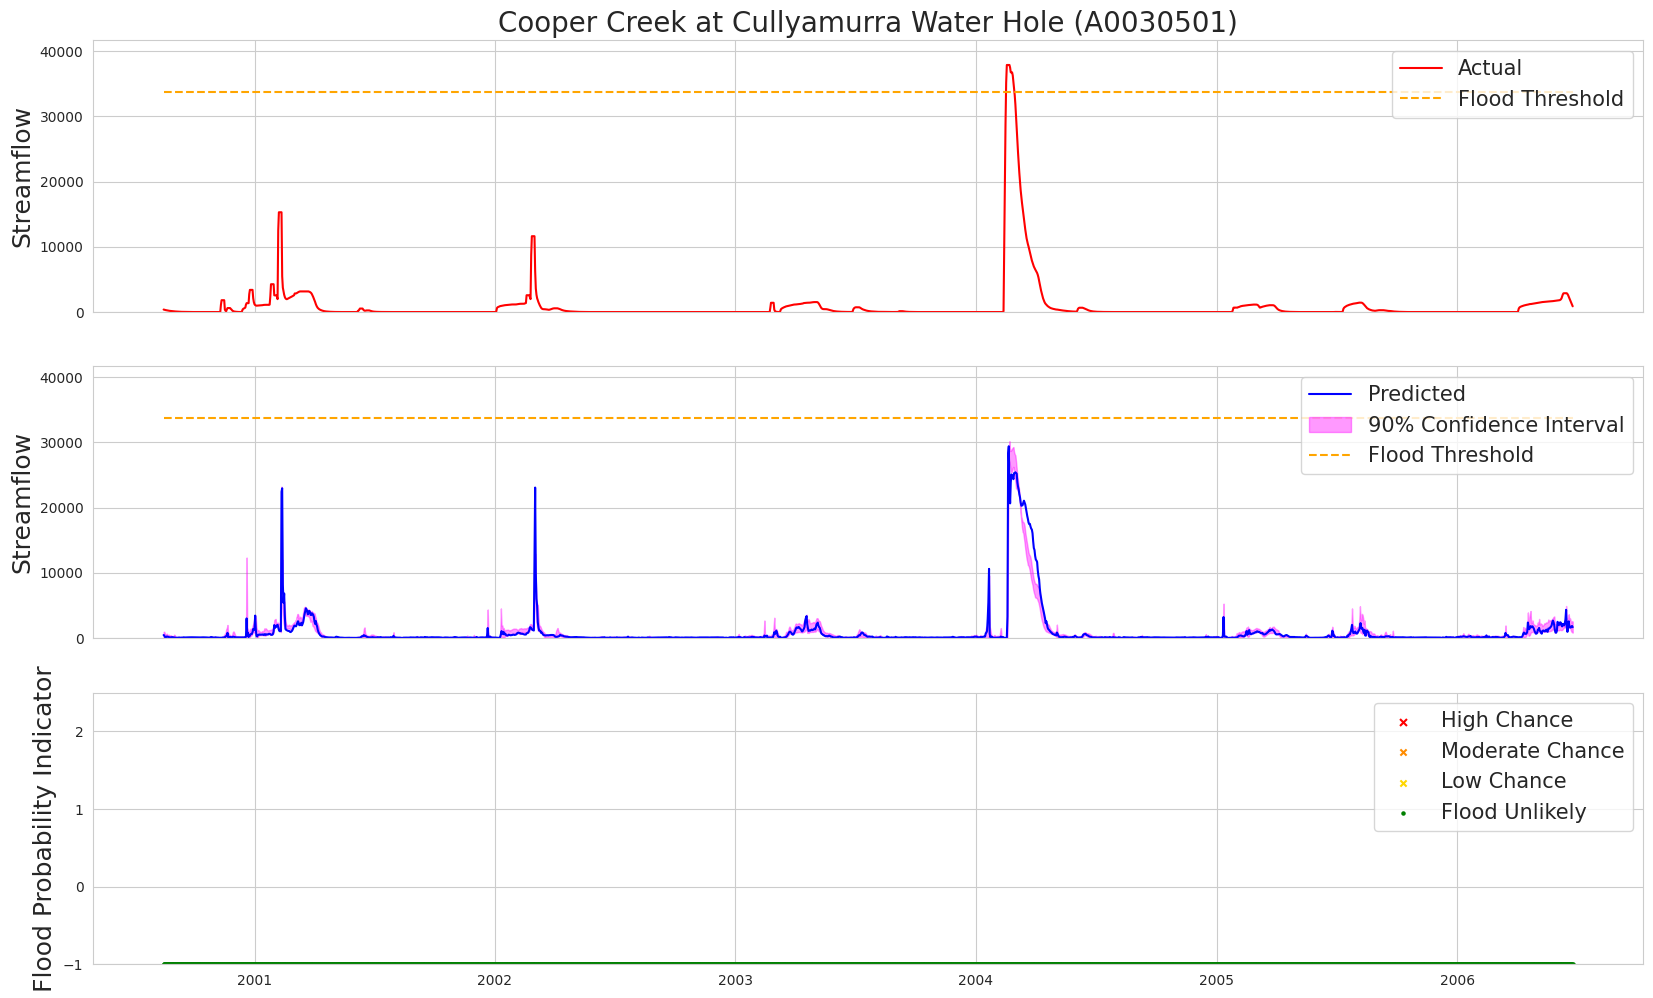

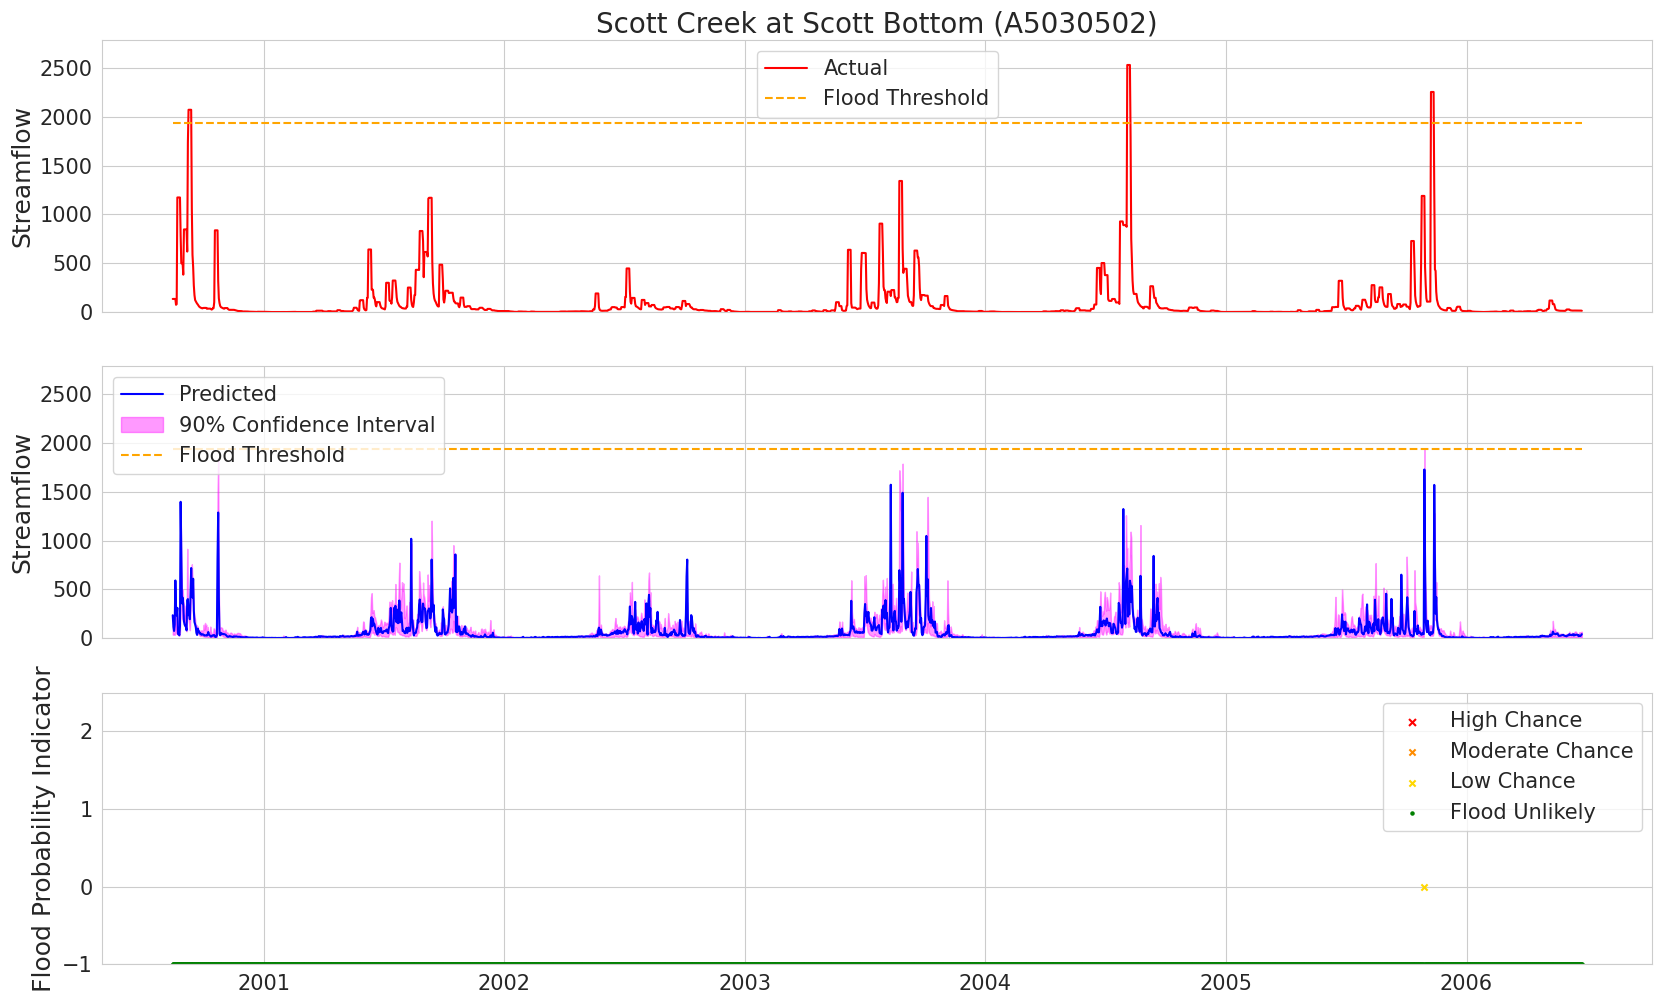

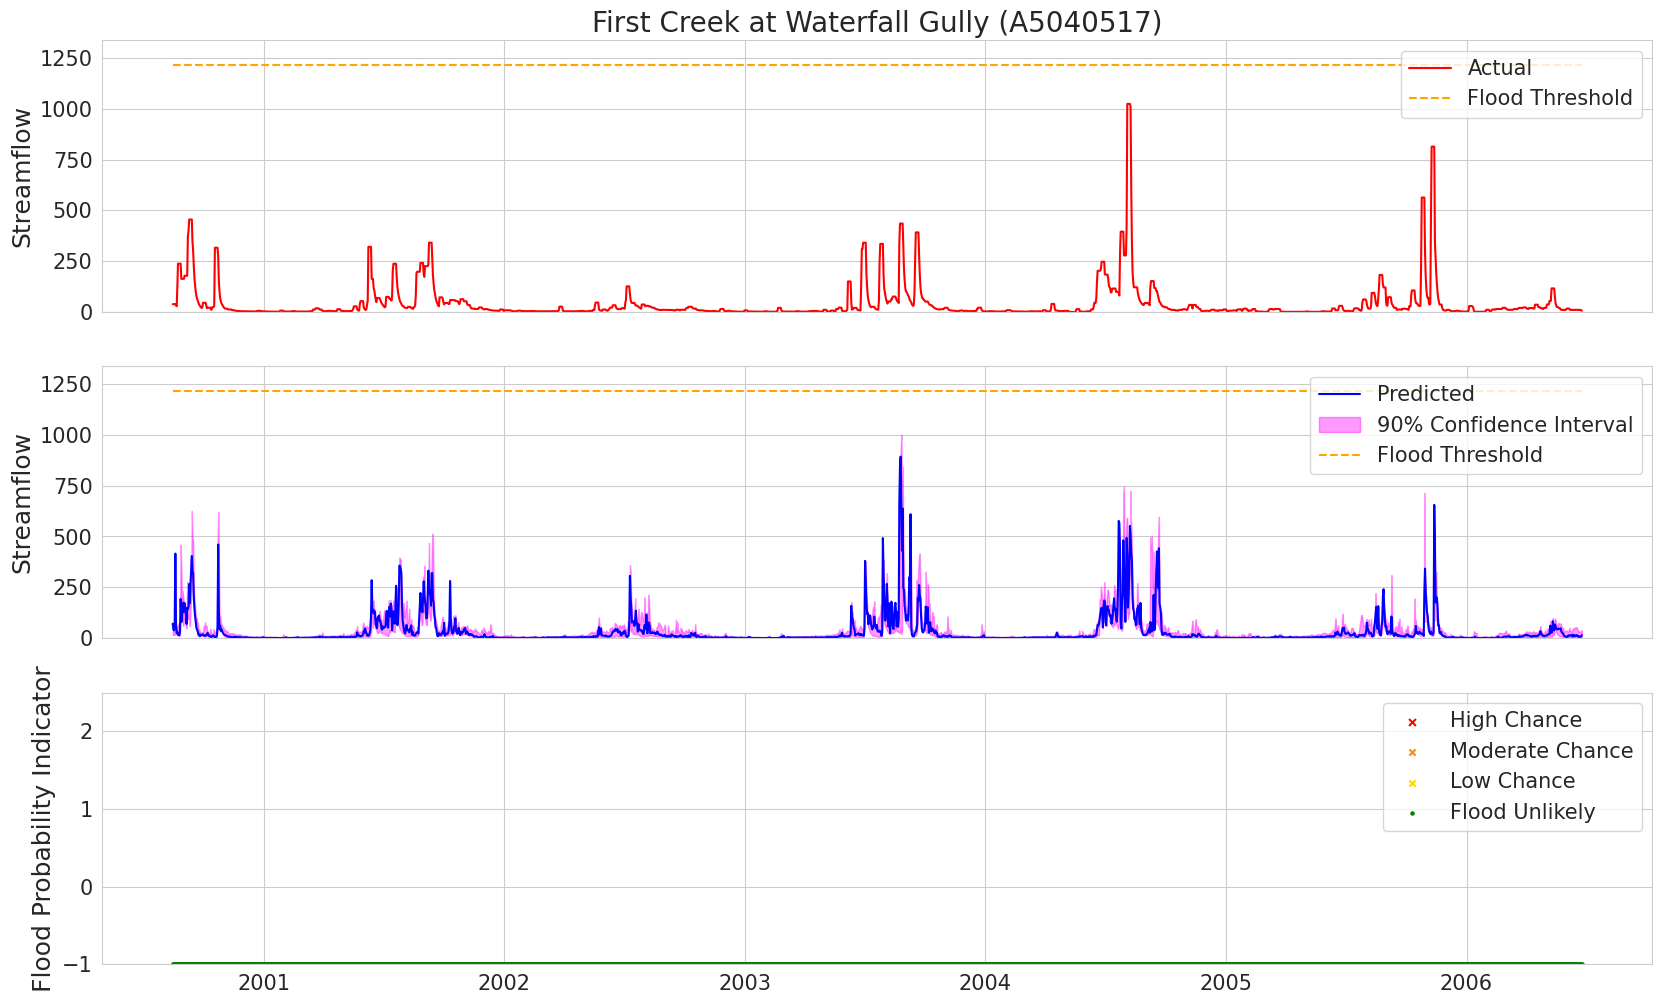

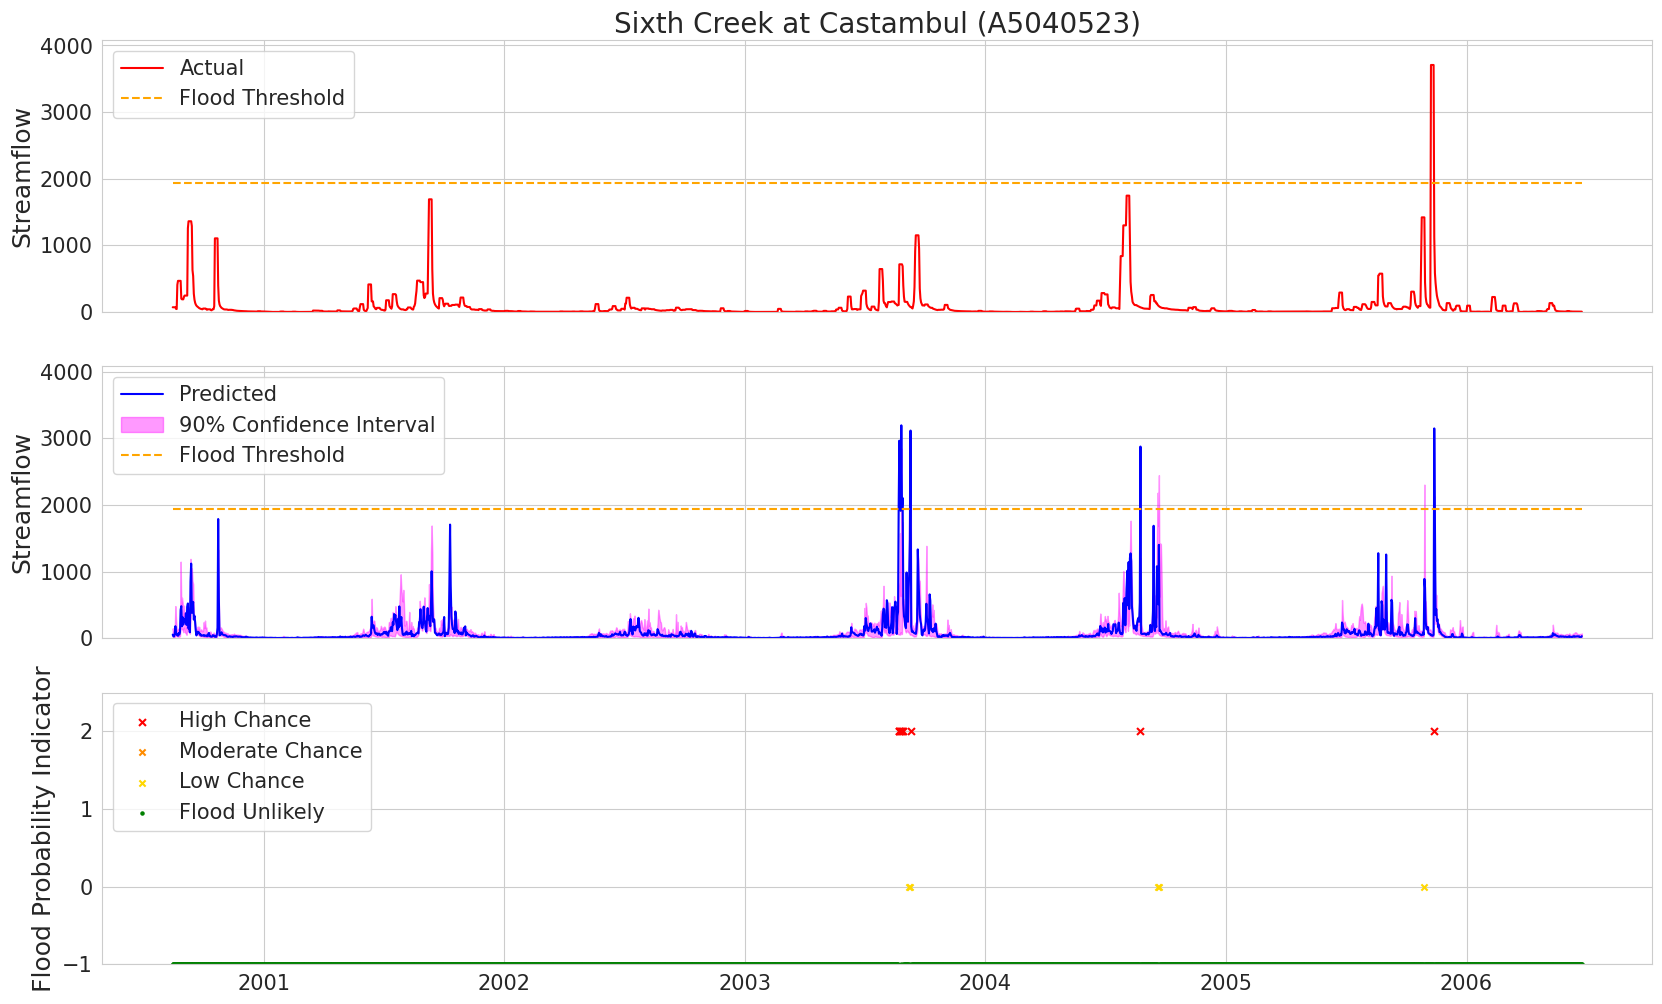

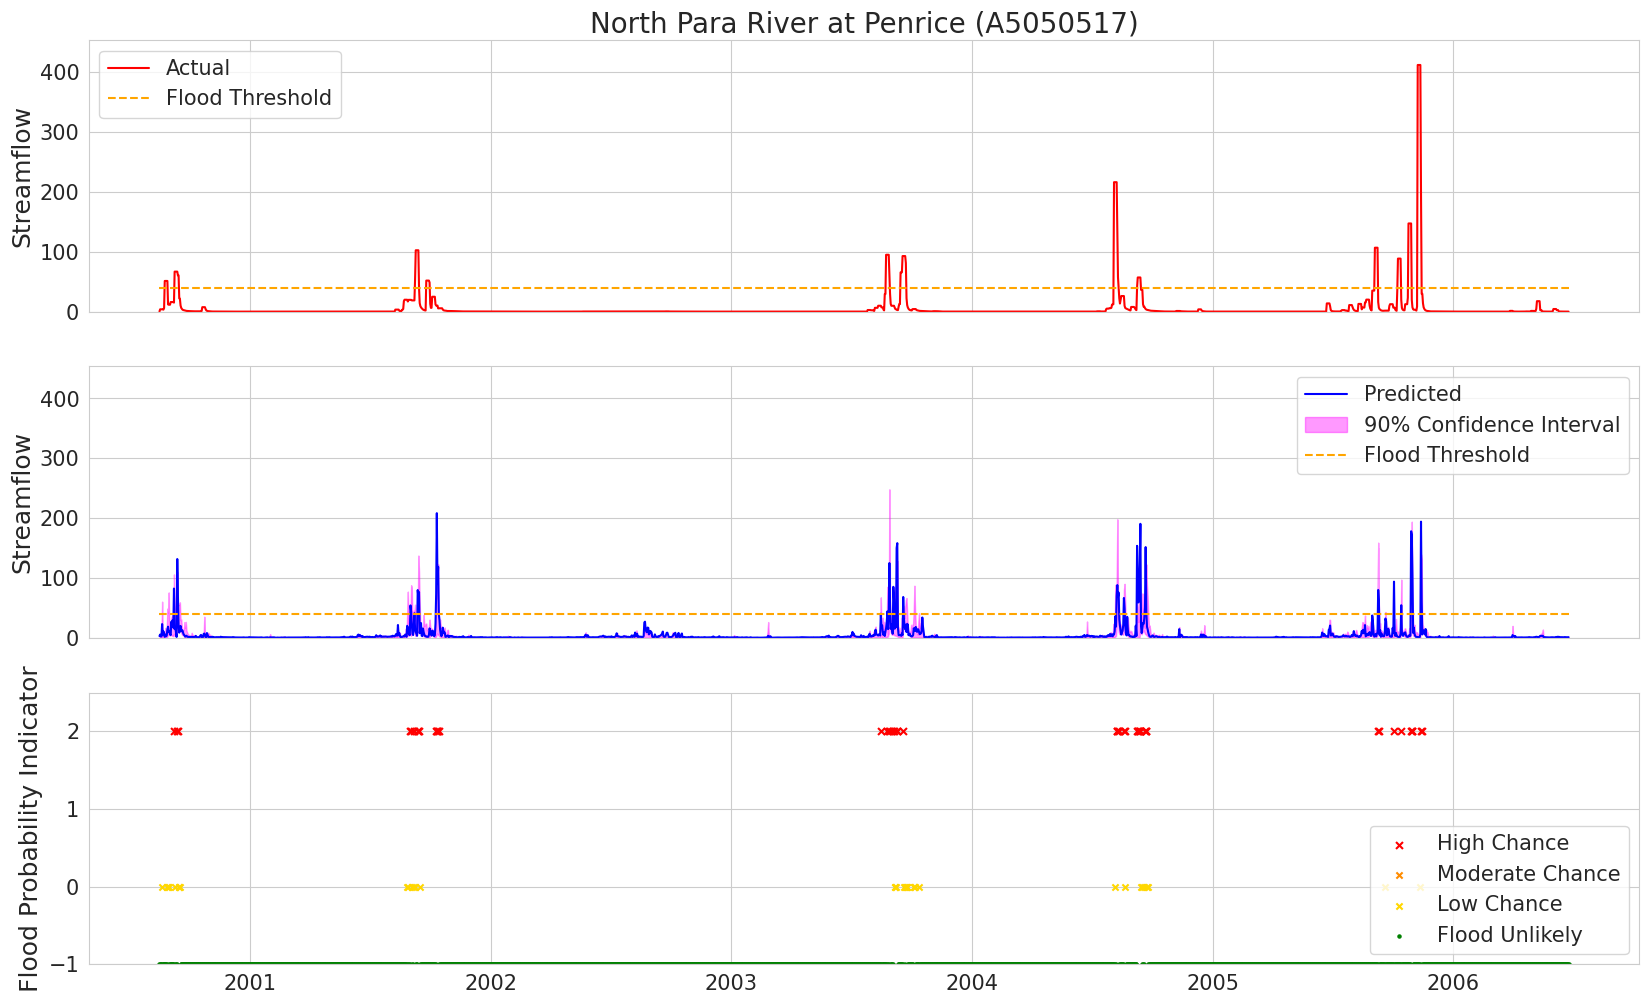

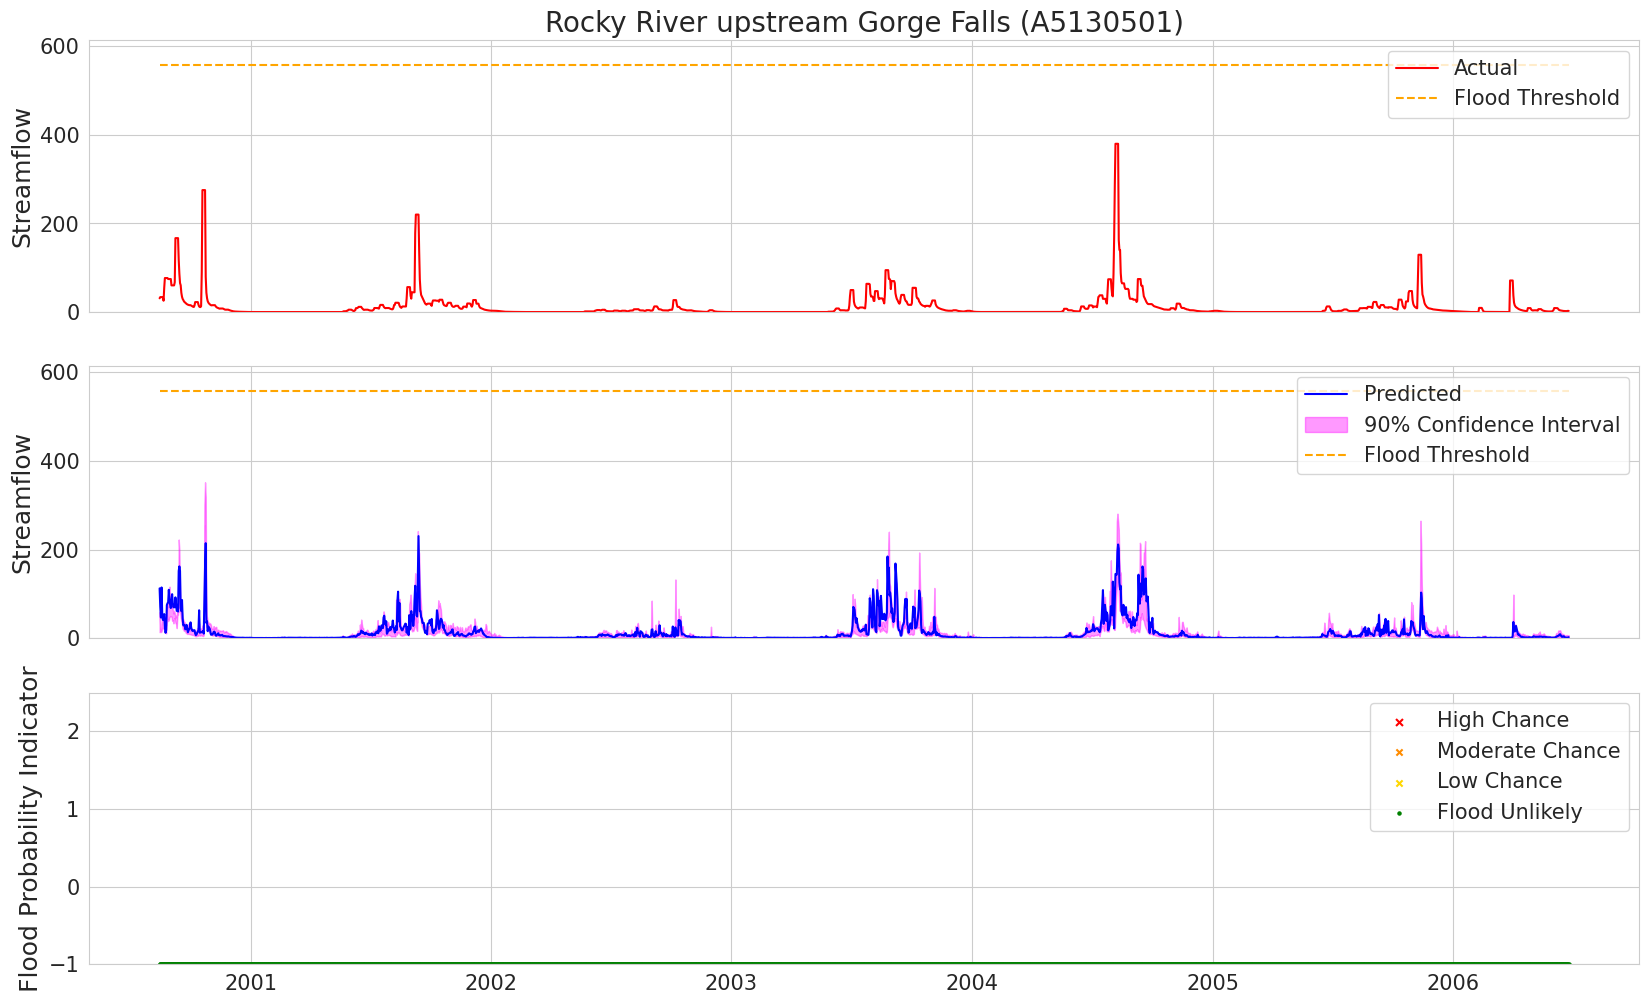

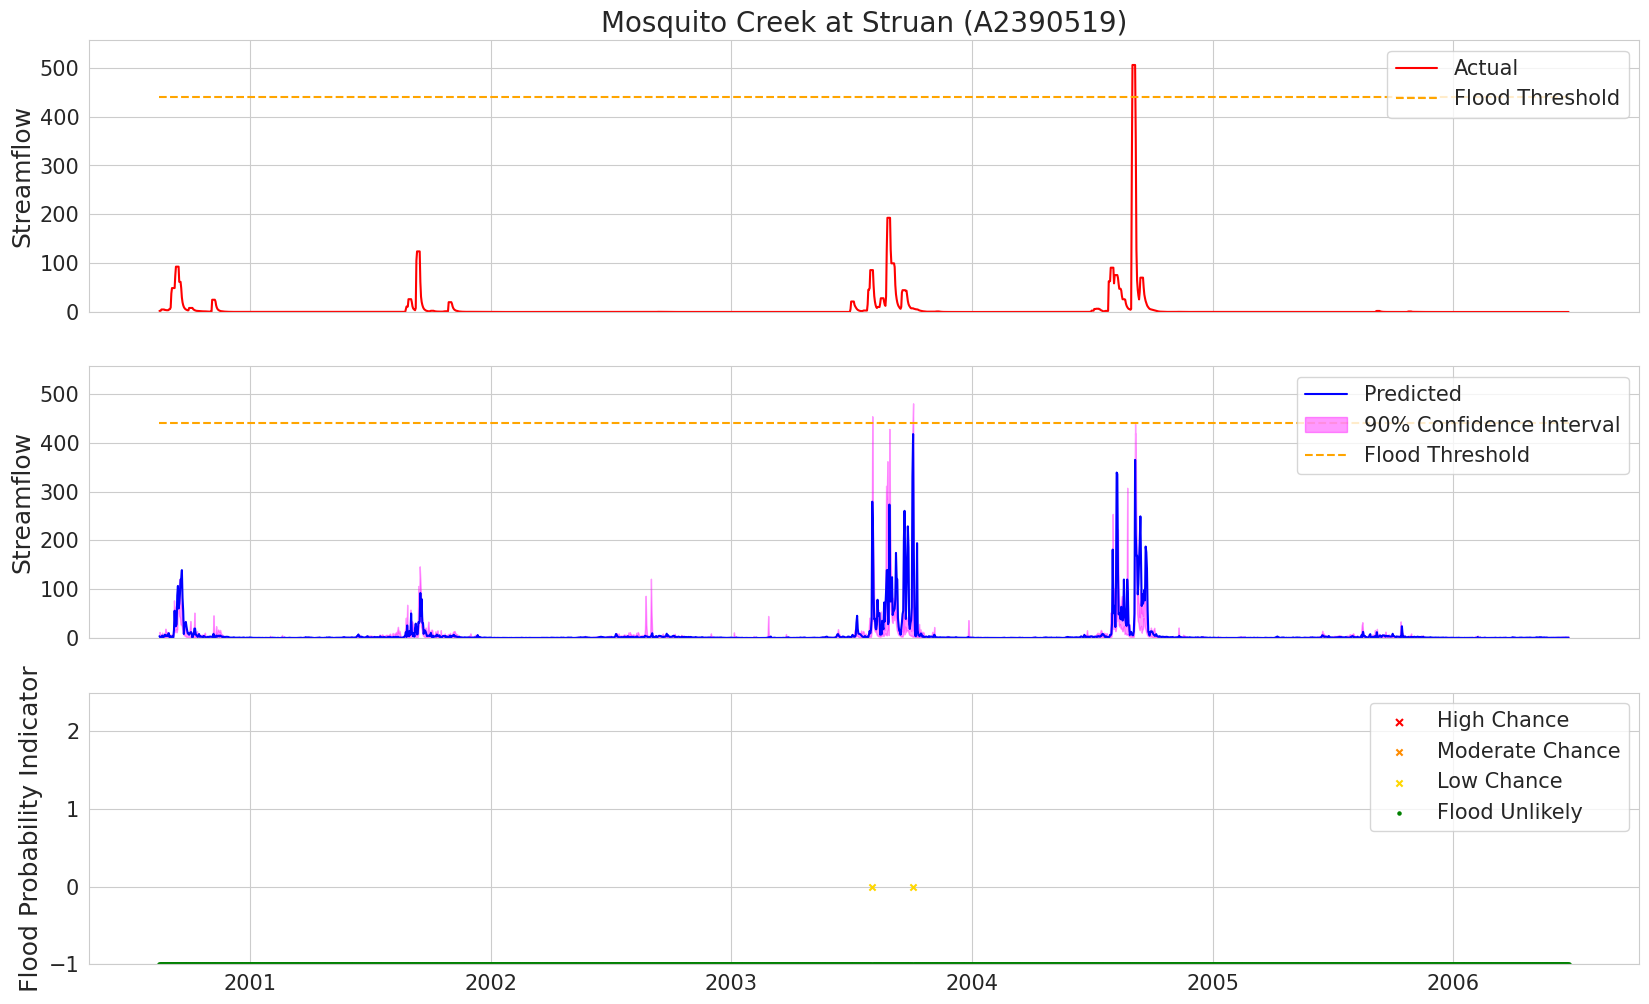

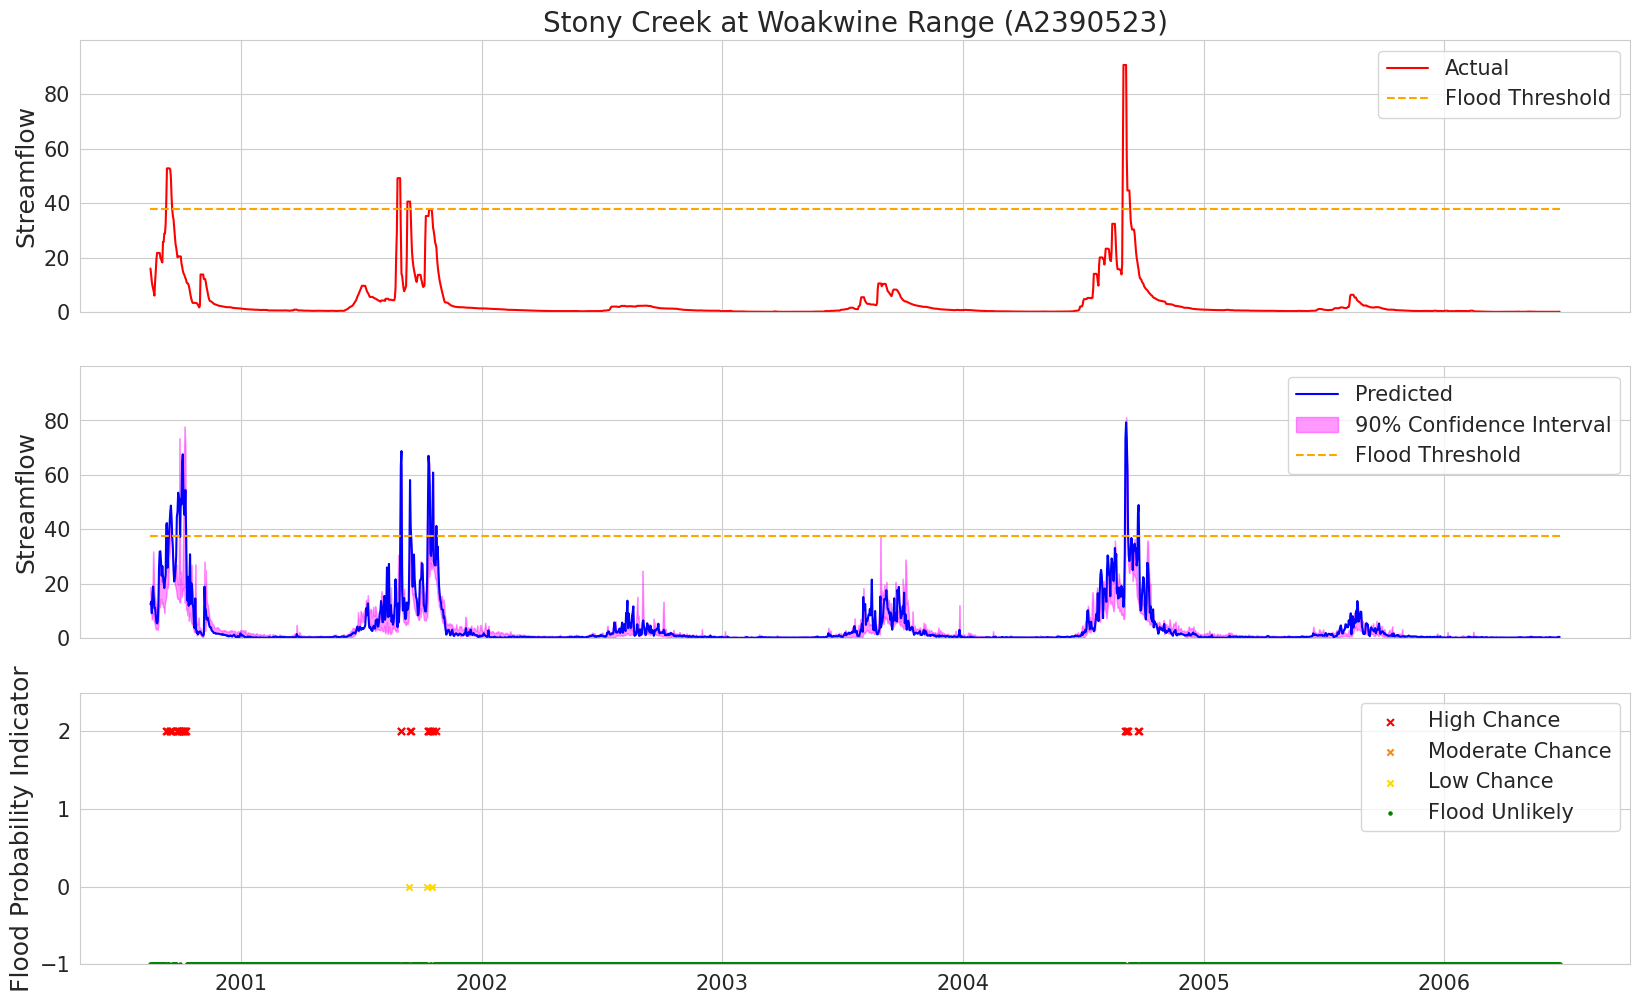

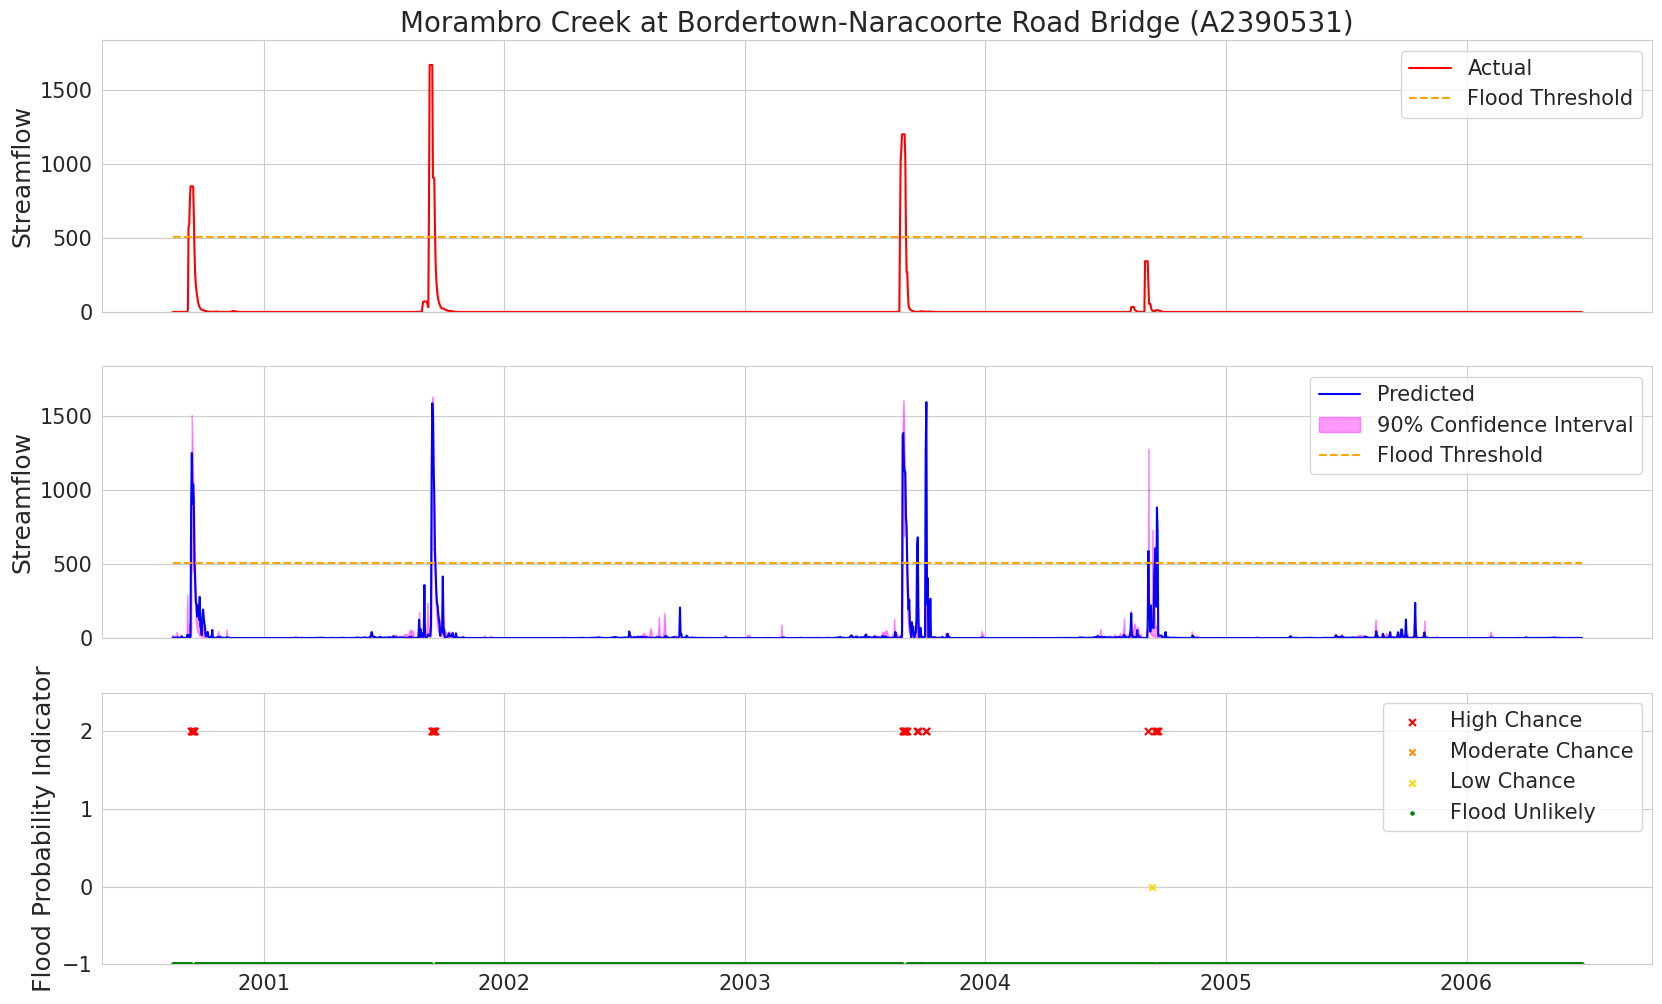

In [10]:
for station_idx, station in enumerate(selected_stations):

    idx = np.where(train_df.columns.droplevel(1).unique().values == station)[0][0]
    (threshold_prob, threshold, year) = calc_thresh(station)
    
    print((station, threshold_prob, threshold, year))
    
    summary_regular, summary_q05, summary_q95 = quantile_ensemble.summary(station)
    print(summary_regular, summary_q05, summary_q95)

    test_min_ = camels_data.scaler_test.min_[idx*len(variable_ts)+1]
    test_scale_ = camels_data.scaler_test.scale_[idx*len(variable_ts)+1]
    

    fig, ax = plt.subplots(3, 1, figsize=(20,12), sharex=True)
    pred = (quantile_ensemble.predictions(station) - test_min_)/test_scale_
    actual = (np_window.test_windows(station) - test_min_)/test_scale_  

    pred = pred.max(axis=1)
    actual = actual.max(axis=1)
    

    for i in range(pred.shape[-1]):
        os.makedirs(f'results/Stage 4/flood_preds/{args.state}-{station}', exist_ok=True)
        np.savetxt(f'results/Stage 4/flood_preds/{args.state}-{station}/pred_{i+1}.txt', pred[...,i])
    np.savetxt(f'results/Stage 4/flood_preds/{args.state}-{station}/actual.txt', actual)

    plt.rcParams.update({'font.size': 15})

    df_date = np_window.test_df[station].reset_index()
    date_values = df_date['date'][9:]

    # date_filter = (date_values > dt.datetime(2011, 1, 1)) & (date_values < dt.datetime(2013, 1, 1))
    # date_values = date_values[date_filter]
    # actual = actual[date_filter]
    # pred = pred[date_filter]
    
    ax1 = ax[0].plot(date_values, actual, color='red', label='Actual')
    ax2 = ax[0].hlines(y=threshold, xmin=date_values.min(), xmax=date_values.max(), linestyle='dashed', label='Flood Threshold', color='orange')

    ax3 = ax[1].plot(date_values, pred[:, 0], color='blue', label='Predicted')
    ax4 = ax[1].fill_between(date_values, pred[:, 1], pred[:, 2], color='magenta', alpha=0.4, label='90% Confidence Interval')
    ax5 = ax[1].hlines(y=threshold, xmin=date_values.min(), xmax=date_values.max(), linestyle='dashed', label='Flood Threshold', color='orange', )
    

    alert = np.array([-1]*len(date_values))

    alert[pred[:, 2] > threshold] = 0
    alert[pred[:, 1] > threshold] = 1
    alert[pred[:, 0] > threshold] = 2

    
    ax6 = ax[2].scatter(date_values[alert==2], alert[alert==2], c='red', s=25, marker='x', label='High Chance')
    ax7 = ax[2].scatter(date_values[alert==1], alert[alert==1], c='darkorange', s=20, marker='x', label='Moderate Chance')
    ax8 = ax[2].scatter(date_values[alert==0], alert[alert==0], c='gold', s=20, marker='x', label='Low Chance')
    ax9 = ax[2].scatter(date_values[alert==-1], alert[alert==-1], c='green', s=5, label='Flood Unlikely')    

    # yellow_alert = () & (pred[:, 0, 0] < threshold) & (pred[:, 0, 1] < threshold)
    # orange_alert = (pred[:, 0, 0] > threshold) & (pred[:, 0, 2] > threshold) & (pred[:, 0, 1] < threshold)
    # red_alert = (pred[:, 0, 0] > threshold) & (pred[:, 0, 1] > threshold) & (pred[:, 0, 2] > threshold)
    # no_alert = (pred[:, 0, 0] < threshold) & (pred[:, 0, 1] < threshold) & (pred[:, 0, 2] < threshold)

    # ax6 = ax[2].scatter(date_values[red_alert], 2 * np.ones(date_values[red_alert].shape), c='red', s=20, marker='x', label='High Chance')
    # ax6 = ax[2].scatter(date_values[orange_alert], np.ones(date_values[orange_alert].shape), c='orangered', s=15, marker='x', label='Moderate Chance')
    # ax6 = ax[2].scatter(date_values[yellow_alert], np.zeros(date_values[yellow_alert].shape), c='goldenrod', s=15, marker='x', label='Low Chance')
    # ax6 = ax[2].scatter(date_values[no_alert], -1 * np.ones(date_values[no_alert].shape), c='green', s=5, label='Flood Unlikely')

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    
    ax[0].set_ylim(0, max(actual.max(), threshold)*1.1)
    ax[1].set_ylim(0, max(actual.max(), threshold)*1.1)
    ax[2].set_ylim(-1, 2.5)
    
    
    ax[0].set_title(f"{station_names[station_idx]}", fontsize=20)
    ax[0].set_ylabel('Streamflow', fontsize=18)
    ax[1].set_ylabel('Streamflow', fontsize=18)
    ax[2].set_ylabel('Flood Probability Indicator', fontsize=18)

    fig.savefig(f'results/Stage 4/flood_preds/{args.state}-{station}/flood_prediction.png', bbox_inches='tight')
    # plt.close(fig)

('136202D', np.float64(0.25), np.float64(6443.630000000001), np.float64(1998.0))


/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at

{'model_name': 'multi-LSTM', 'input_width': 5, 'label_width': 5, 'station': '136202D', 'inputs': "['precipitation_deficit', 'streamflow_MLd_inclInfilled', 'tmax_AWAP', 'tmin_AWAP', 'year_cos', 'year_sin']", 'NSE': np.float64(0.17081348021962817), 'SER_1%': np.float64(1.1831963633861133), 'SER_2%': np.float64(0.6575326144734496), 'SER_5%': np.float64(0.27933998874025545), 'SER_10%': np.float64(0.1416907845723647), 'SER_25%': np.float64(0.05669983183091477), 'SER_50%': np.float64(0.028421375861104832), 'SER_75%': np.float64(0.021431554979591545), 'RMSE': np.float64(0.018135063673660086), 'f1_score_individual_1%': 0.2885572139303483, 'f1_score_individual_2%': 0.3826879271070615, 'f1_score_individual_5%': 0.4787379972565158, 'f1_score_individual_10%': 0.4178159620167307, 'f1_score_individual_25%': 0.3820536540240518, 'f1_score_individual_50%': 0.6304520222045995, 'f1_score_individual_75%': 0.8117776959882224, 'f1_score_individual_all': 0.9398436253390777} {'model_name': 'multi-LSTM', 'inpu

/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/scratch/pbs.6170161.kman.restech.unsw.edu.au/ipykernel_1051055/4079591224.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{river_region}-{station_names[station_idx]}", fontsize=20)


('136203A', np.float64(0.25), np.float64(2488.68), np.float64(1999.0))


/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at

{'model_name': 'multi-LSTM', 'input_width': 5, 'label_width': 5, 'station': '136203A', 'inputs': "['precipitation_deficit', 'streamflow_MLd_inclInfilled', 'tmax_AWAP', 'tmin_AWAP', 'year_cos', 'year_sin']", 'NSE': np.float64(0.029852775488086913), 'SER_1%': np.float64(0.786991164729193), 'SER_2%': np.float64(0.5250743947027621), 'SER_5%': np.float64(0.28613807866438246), 'SER_10%': np.float64(0.14666459871725984), 'SER_25%': np.float64(0.06011766854942327), 'SER_50%': np.float64(0.03053209240620585), 'SER_75%': np.float64(0.023686070669631156), 'RMSE': np.float64(0.023686070669631156), 'f1_score_individual_1%': 0.3155080213903743, 'f1_score_individual_2%': 0.32967032967032966, 'f1_score_individual_5%': 0.22329376854599406, 'f1_score_individual_10%': 0.25671202648032365, 'f1_score_individual_25%': 0.4048858204992034, 'f1_score_individual_50%': 0.6657022302591923, 'f1_score_individual_75%': 0.7855967830378359, 'f1_score_individual_all': 0.7855967830378359} {'model_name': 'multi-LSTM', 'i

/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/scratch/pbs.6170161.kman.restech.unsw.edu.au/ipykernel_1051055/4079591224.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{river_region}-{station_names[station_idx]}", fontsize=20)


('136208A', np.float64(0.25), np.float64(12651.799999999997), np.float64(1996.0))


/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at

{'model_name': 'multi-LSTM', 'input_width': 5, 'label_width': 5, 'station': '136208A', 'inputs': "['precipitation_deficit', 'streamflow_MLd_inclInfilled', 'tmax_AWAP', 'tmin_AWAP', 'year_cos', 'year_sin']", 'NSE': np.float64(0.12545107482325019), 'SER_1%': np.float64(1.5970010909613856), 'SER_2%': np.float64(0.9814589542232912), 'SER_5%': np.float64(0.4140002652194058), 'SER_10%': np.float64(0.20749344424950433), 'SER_25%': np.float64(0.08303601556282755), 'SER_50%': np.float64(0.041503402220283245), 'SER_75%': np.float64(0.03217080706161792), 'RMSE': np.float64(0.03217080706161792), 'f1_score_individual_1%': 0.18181818181818182, 'f1_score_individual_2%': 0.43805309734513276, 'f1_score_individual_5%': 0.46648793565683644, 'f1_score_individual_10%': 0.4363103953147877, 'f1_score_individual_25%': 0.40135403635293254, 'f1_score_individual_50%': 0.6611134020618556, 'f1_score_individual_75%': 0.784219001610306, 'f1_score_individual_all': 0.784219001610306} {'model_name': 'multi-LSTM', 'inpu

/srv/scratch/z5370003/miniconda3/envs/dl-env/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/scratch/pbs.6170161.kman.restech.unsw.edu.au/ipykernel_1051055/4079591224.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_title(f"{river_region}-{station_names[station_idx]}", fontsize=20)


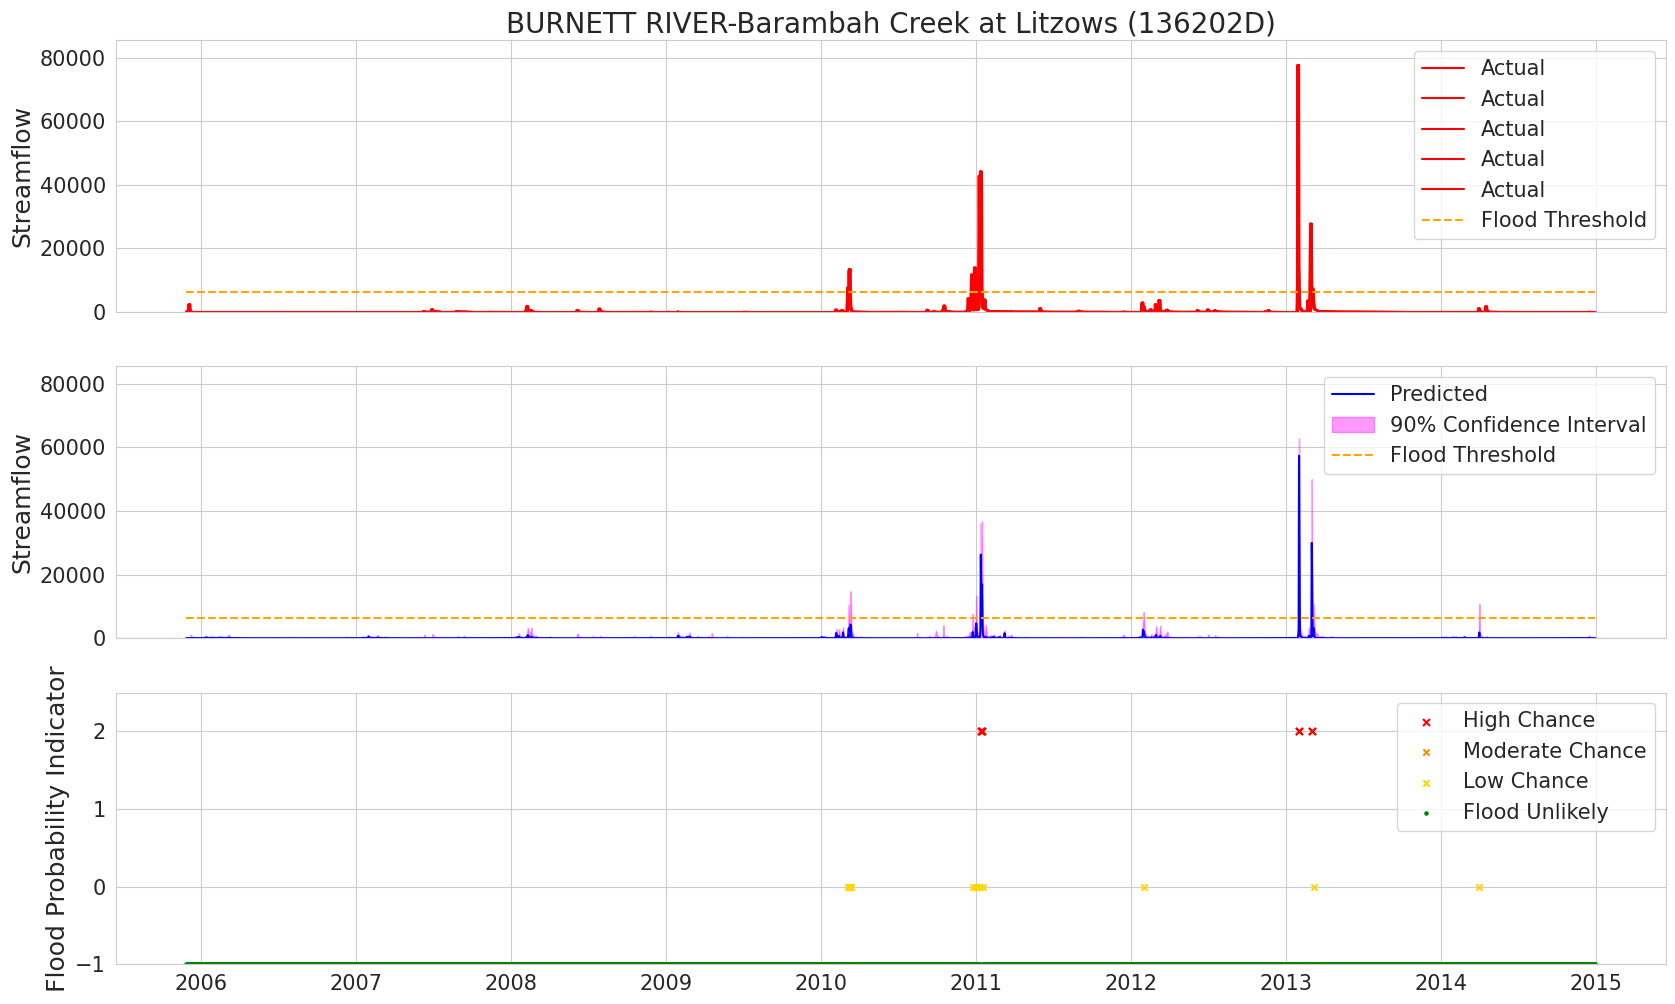

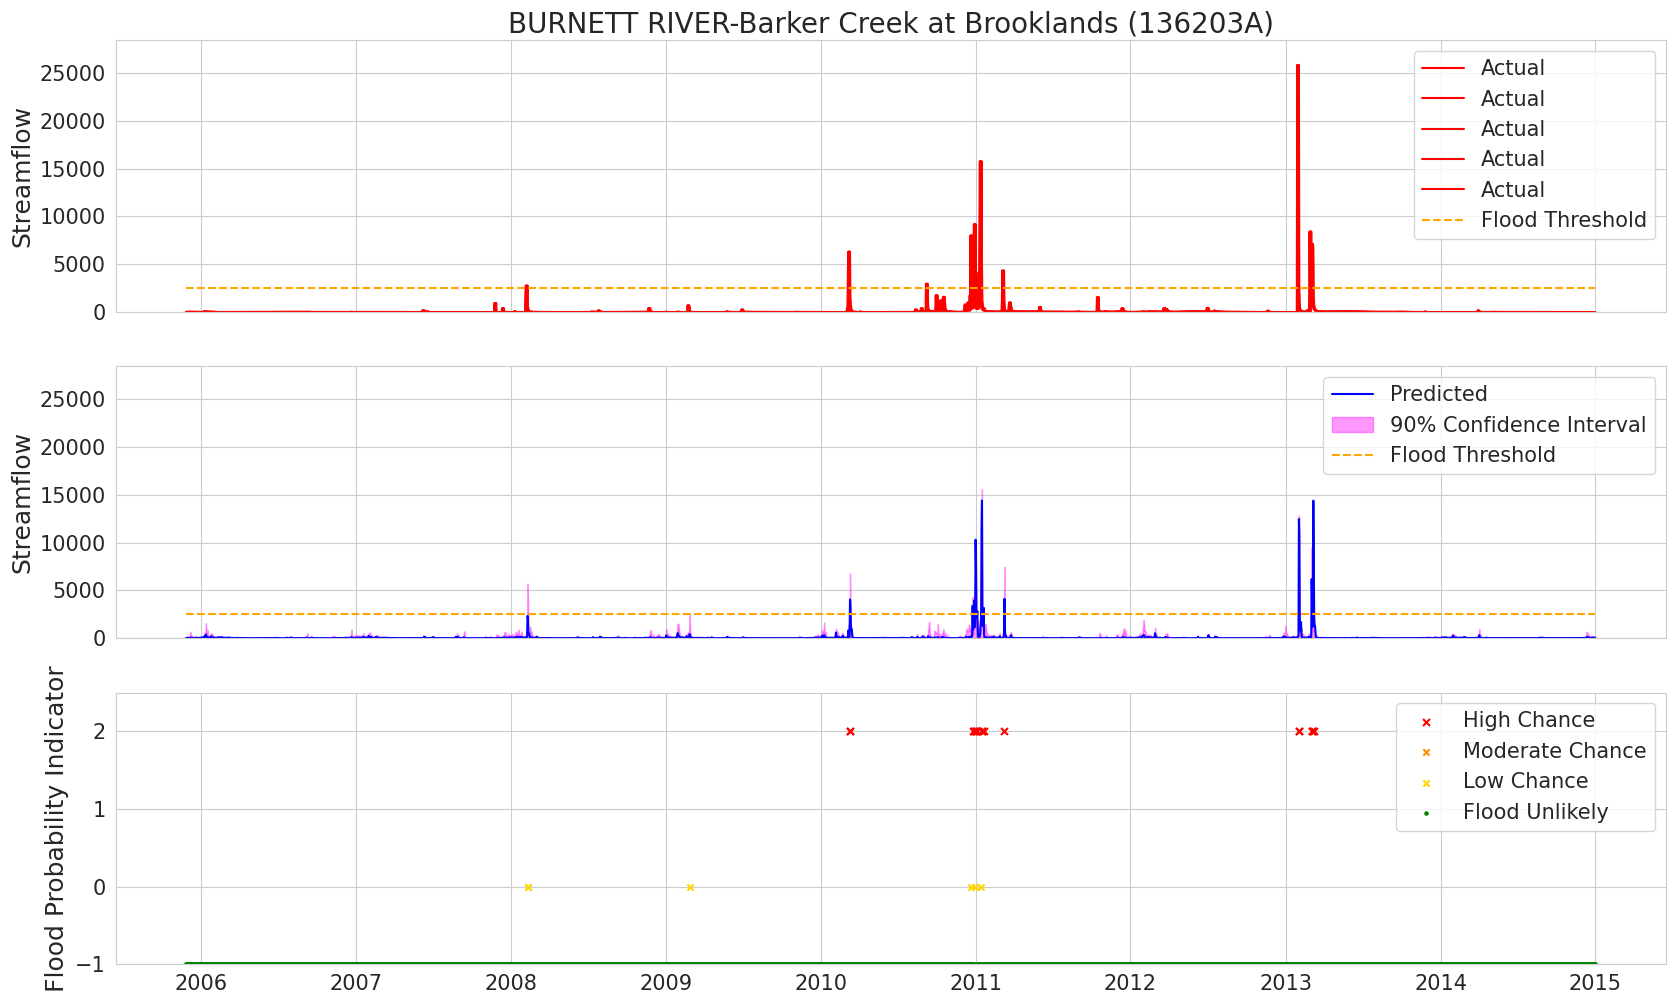

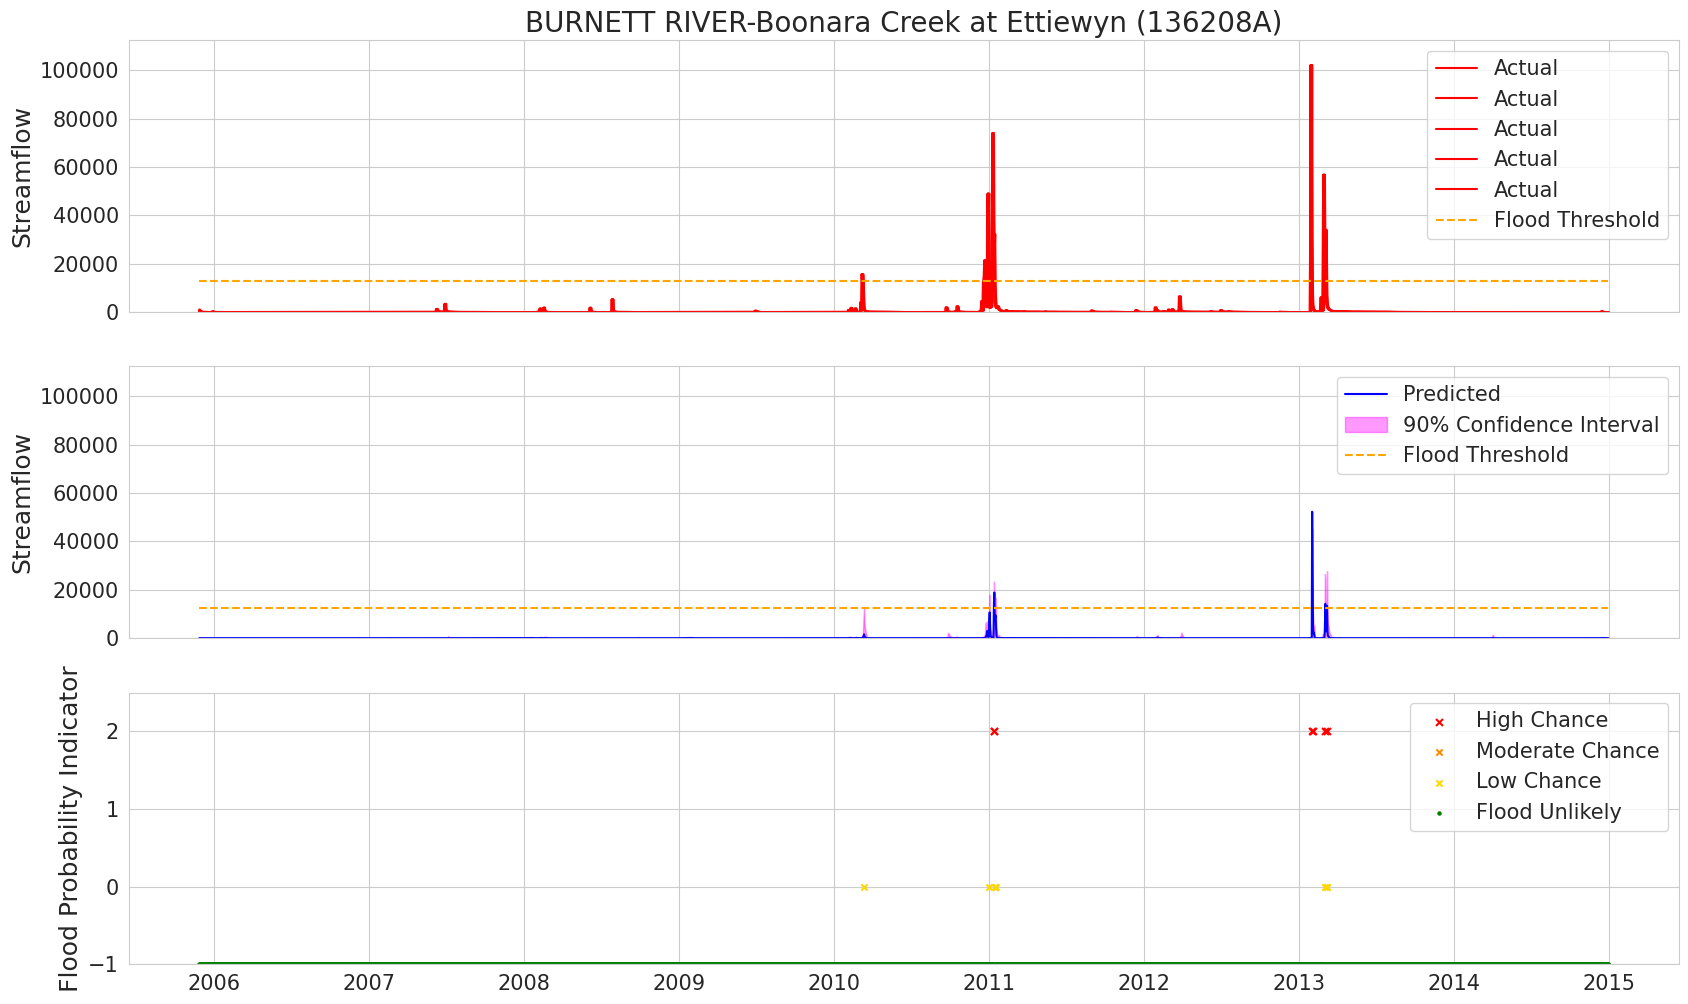

In [39]:
for station_idx, station in enumerate(selected_stations):

    idx = np.where(train_df.columns.droplevel(1).unique().values == station)[0][0]
    (threshold_prob, threshold, year) = calc_thresh(station)
    
    print((station, threshold_prob, threshold, year))
    
    summary_regular, summary_q05, summary_q95 = quantile_ensemble.summary(station)
    print(summary_regular, summary_q05, summary_q95)

    test_min_ = camels_data.scaler_test.min_[idx*len(variable_ts)+1]
    test_scale_ = camels_data.scaler_test.scale_[idx*len(variable_ts)+1]
    

    fig, ax = plt.subplots(3, 1, figsize=(20,12), sharex=True)
    pred = (quantile_ensemble.predictions(station) - test_min_)/test_scale_
    actual = (multi_window.test_windows(station) - test_min_)/test_scale_  

    # pred = pred.mean(axis=1)
    # actual = actual.mean(axis=1)
    

    for i in range(pred.shape[-1]):
        os.makedirs(f'results/Stage 4/flood_preds/{args.state}-{station}', exist_ok=True)
        np.savetxt(f'results/Stage 4/flood_preds/{args.state}-{station}/pred_{i+1}.txt', pred[...,i])
    np.savetxt(f'results/Stage 4/flood_preds/{args.state}-{station}/actual.txt', actual)

    plt.rcParams.update({'font.size': 15})

    df_date = multi_window.test_df[station].reset_index()
    date_values = df_date['date'][9:]

    # date_filter = (date_values > dt.datetime(2011, 1, 1)) & (date_values < dt.datetime(2013, 1, 1))
    # date_values = date_values[date_filter]
    # actual = actual[date_filter]
    # pred = pred[date_filter]
    
    ax1 = ax[0].plot(date_values, actual, color='red', label='Actual')
    ax2 = ax[0].hlines(y=threshold, xmin=date_values.min(), xmax=date_values.max(), linestyle='dashed', label='Flood Threshold', color='orange')

    ax3 = ax[1].plot(date_values, pred[:, 0, 0], color='blue', label='Predicted')
    ax4 = ax[1].fill_between(date_values, pred[:, 0, 1], pred[:, 0, 2], color='magenta', alpha=0.4, label='90% Confidence Interval')
    ax5 = ax[1].hlines(y=threshold, xmin=date_values.min(), xmax=date_values.max(), linestyle='dashed', label='Flood Threshold', color='orange', )
    

    alert = np.array([-1]*len(date_values))

    alert[pred[:, 0, 2] > threshold] = 0
    alert[pred[:, 0, 0] > threshold] = 2
    alert[pred[:, 0, 1] > threshold] = 1

    
    ax6 = ax[2].scatter(date_values[alert==2], alert[alert==2], c='red', s=25, marker='x', label='High Chance')
    ax7 = ax[2].scatter(date_values[alert==1], alert[alert==1], c='darkorange', s=20, marker='x', label='Moderate Chance')
    ax8 = ax[2].scatter(date_values[alert==0], alert[alert==0], c='gold', s=20, marker='x', label='Low Chance')
    ax9 = ax[2].scatter(date_values[alert==-1], alert[alert==-1], c='green', s=5, label='Flood Unlikely')    

    # yellow_alert = () & (pred[:, 0, 0] < threshold) & (pred[:, 0, 1] < threshold)
    # orange_alert = (pred[:, 0, 0] > threshold) & (pred[:, 0, 2] > threshold) & (pred[:, 0, 1] < threshold)
    # red_alert = (pred[:, 0, 0] > threshold) & (pred[:, 0, 1] > threshold) & (pred[:, 0, 2] > threshold)
    # no_alert = (pred[:, 0, 0] < threshold) & (pred[:, 0, 1] < threshold) & (pred[:, 0, 2] < threshold)

    # ax6 = ax[2].scatter(date_values[red_alert], 2 * np.ones(date_values[red_alert].shape), c='red', s=20, marker='x', label='High Chance')
    # ax6 = ax[2].scatter(date_values[orange_alert], np.ones(date_values[orange_alert].shape), c='orangered', s=15, marker='x', label='Moderate Chance')
    # ax6 = ax[2].scatter(date_values[yellow_alert], np.zeros(date_values[yellow_alert].shape), c='goldenrod', s=15, marker='x', label='Low Chance')
    # ax6 = ax[2].scatter(date_values[no_alert], -1 * np.ones(date_values[no_alert].shape), c='green', s=5, label='Flood Unlikely')

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    
    ax[0].set_ylim(0, max(actual.max(), threshold)*1.1)
    ax[1].set_ylim(0, max(actual.max(), threshold)*1.1)
    ax[2].set_ylim(-1, 2.5)
    
    
    ax[0].set_title(f"{river_region}-{station_names[station_idx]}", fontsize=20)
    ax[0].set_ylabel('Streamflow', fontsize=18)
    ax[1].set_ylabel('Streamflow', fontsize=18)
    ax[2].set_ylabel('Flood Probability Indicator', fontsize=18)

    fig.savefig(f'results/Stage 4/flood_preds/{args.state}-{station}/flood_prediction.png', bbox_inches='tight')
    # plt.close(fig)

In [12]:
# pred = quantile_ensemble.predictions(station)

In [13]:
# def flood_extent(streamflow_ts):

#     station_name = streamflow_ts.name

#     flow_data = pd.DataFrame(streamflow_ts)
#     flow_data = flow_data.sort_values(by=station_name, ascending=True)

#     flow_data.loc[~flow_data[station_name].isnull(), 'idx'] = np.arange((~flow_data[station_name].isnull()).sum())
#     flow_data.loc[:, 'prob'] =  (flow_data.idx + 1)/(1+len(flow_data))
    
#     # flow_data.loc[flow_data[station_name].isnull(), 'prob'] = np.nan
#     flood_prob = flow_data.prob
#     flood_prob.name = station_name
#     flood_prob = flood_prob.sort_index()

#     return flood_prob.reset_index(drop=True)

In [14]:
# pred_t = np.transpose(pred, axes=(0, 2, 1))
# pred_acc = np.roll(pred_t, -1, axis=-1) - pred_t
# pred_acc = pred_acc[..., :-1]
# pred_acc.shape

In [15]:
# plt.plot(np.arange(1, 5), pred_acc[0, 0], label='acceleration')
# plt.plot(pred_t[0, 0], label='streamflow')
# plt.plot(np.arange(1, 5), np.cumsum(pred_acc[0, 0]), label='cummulative-acceleration')
# plt.legend()

In [16]:
# pred_mean_acc = pred_acc.mean(-1)

In [17]:
# def sigmoid(x):
#     return 1/(1 + np.exp(-x))

In [18]:
# train_flow = np.array(multi_window.train_df[station][multi_window.label_columns])
# min_ = camels_data.scaler.min_[idx*len(variable_ts)+1]
# scale_ = camels_data.scaler.scale_[idx*len(variable_ts)+1]
# train_flow = ((train_flow - min_)/scale_).flatten()
# train_acc = np.roll(train_flow, -1) - train_flow
# train_acc = train_acc[:-1]


# fig, ax = plt.subplots(4, 1, figsize=(16, 10))
# s = 1900
# e = 2000

# train_flood_prob = train_acc/train_acc.max()


# ax[0].plot(train_flow[s:e], color='black', label='streamflow')

# ax[1].plot(train_acc[s:e], color='blue', label='acceleration')

# ax[2].plot(train_flood_prob[s:e], color='red', label='normalised_acceleration')
# ax[2].set_ylim(-1, 1)

# ax[3].plot(np.clip(train_flood_prob[s:e], 0, None), color='green', label='flood_probability')
# ax[3].set_ylim(-1, 1)

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
# ax[3].legend()

# # ax[1].set_ylim(0, 1)
